In [1]:
from plotting_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Informer dataset analysis

In [2]:
amine2_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem2rxns.xlsx")
amine4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem4rxns.xlsx")
amine6_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem6rxns.xlsx")

cat4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem4rxns.xlsx")
cat8_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem8rxns.xlsx")
cat12_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem12rxns.xlsx")

In [19]:
cat_dicts = [{}, {}]
for k, v in cat4_dict.items():
    for i in range(2) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(2):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.211
0.232
Baseline
0.266
0.093
RPC
0.209
0.239
LRRF
0.25
0.258
RFC
0.202
0.254
LR
-0.019
0.139
KNN
0.126
0.217
---------------------------
1
RFR
0.295
0.299
Baseline
0.306
0.145
RPC
0.263
0.288
LRRF
0.334
0.319
RFC
0.257
0.305
LR
-0.022
0.127
KNN
0.236
0.262
---------------------------


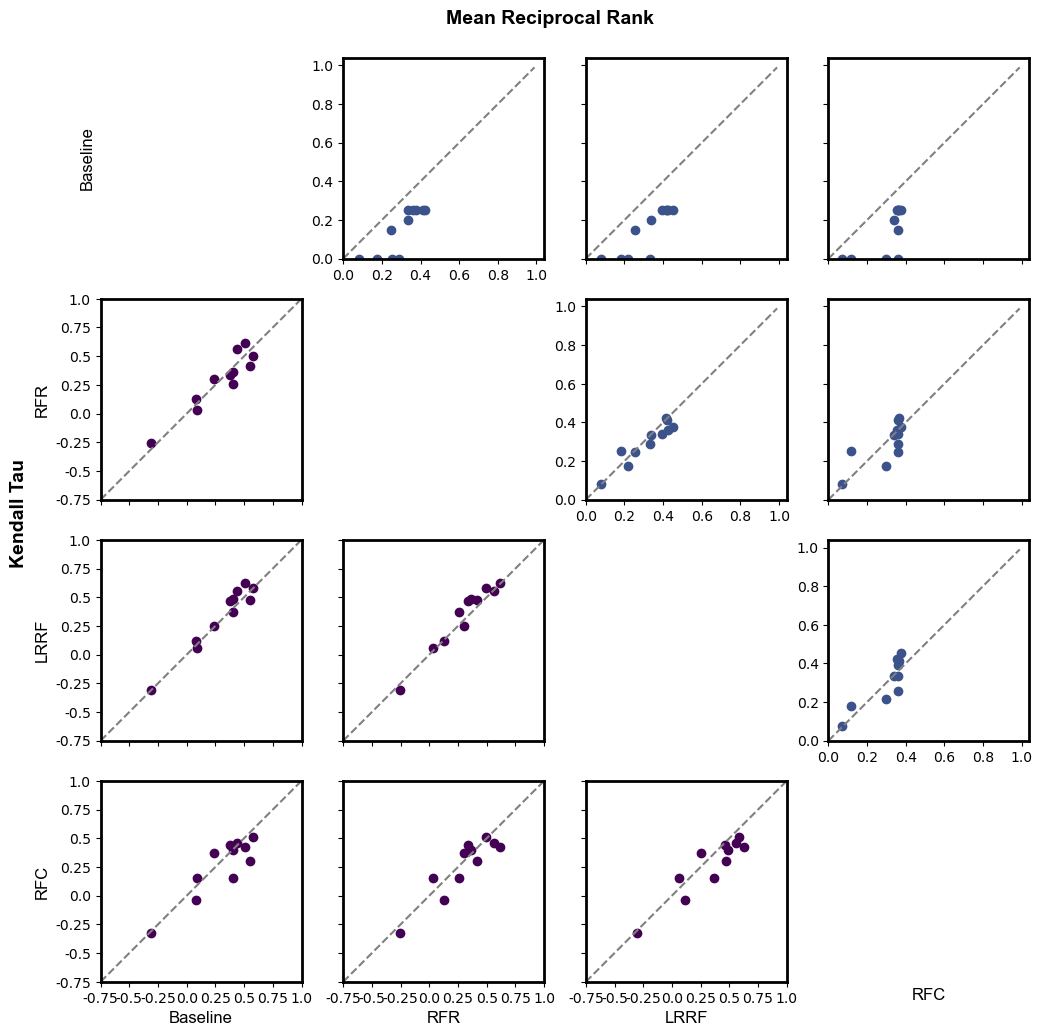

In [25]:
trellis_of_algs(
        cat_dicts[1],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "mean_reciprocal_rank",
        filename=None
    )

In [23]:
amine2_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        amine2_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in amine2_dicts[i].items():
        print(k)
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.326
0.448
Baseline
0.198
0.195
RPC
0.149
0.356
LRRF
0.156
0.392
RFC
0.18
0.358
LR
-0.047
0.243
KNN
0.108
0.409
---------------------------
1
RFR
0.402
0.463
Baseline
0.343
0.195
RPC
0.314
0.433
LRRF
0.293
0.439
RFC
0.299
0.382
LR
-0.08
0.208
KNN
0.15
0.435
---------------------------
2
RFR
0.273
0.487
Baseline
0.173
0.236
RPC
0.122
0.416
LRRF
0.159
0.437
RFC
0.167
0.389
LR
0.027
0.28
KNN
0.19
0.428
---------------------------
3
RFR
0.343
0.452
Baseline
0.313
0.245
RPC
0.322
0.4
LRRF
0.355
0.412
RFC
0.267
0.342
LR
-0.048
0.219
KNN
0.305
0.381
---------------------------


RFR
7.0
0.676

Baseline
5.0
0.735

RPC
10.4
0.537

LRRF
3.9
0.802

RFC
3.0
0.808

LR
19.2
0.357

KNN
3.4
0.816



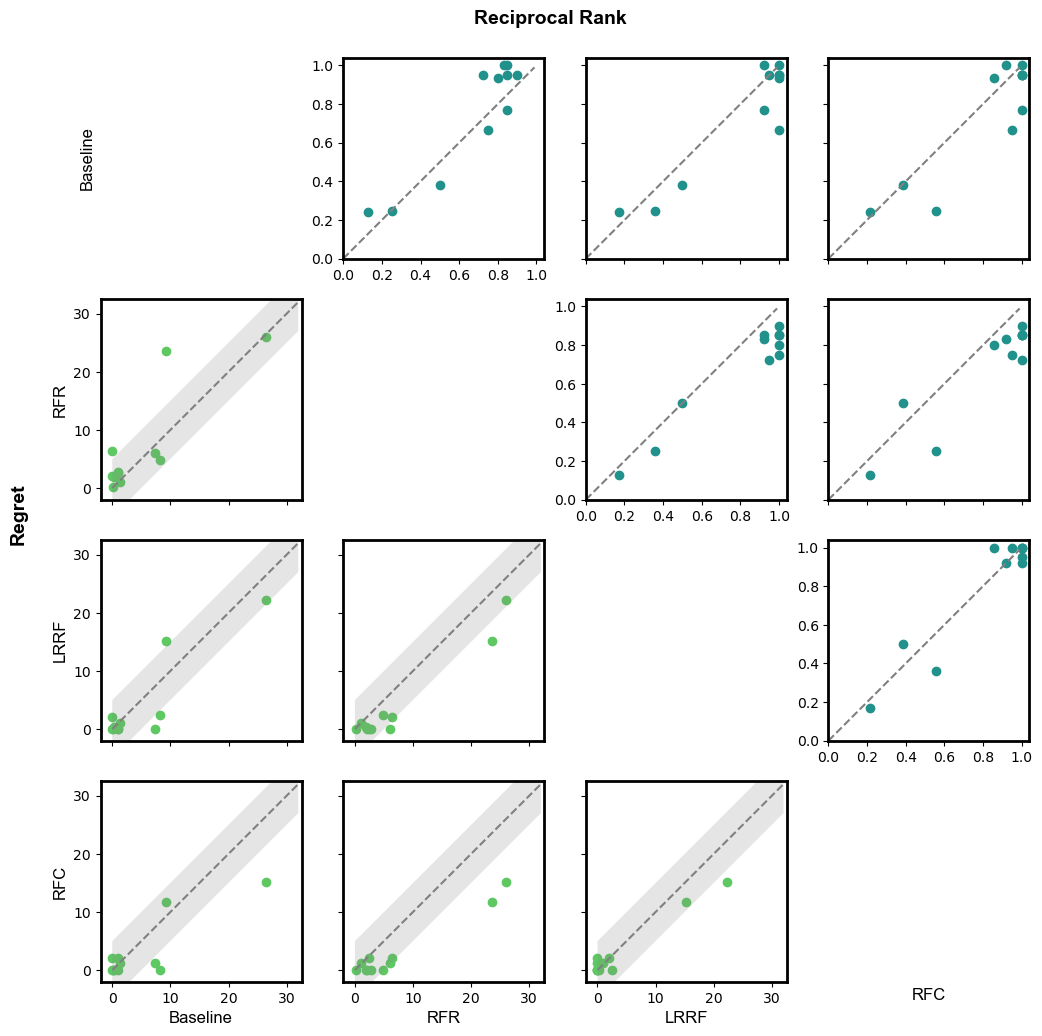

In [5]:
trellis_of_algs(
        amine2_dicts[0],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

## Looking at stability of models

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

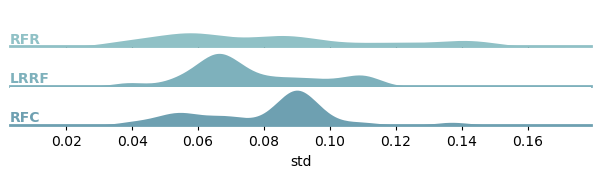

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

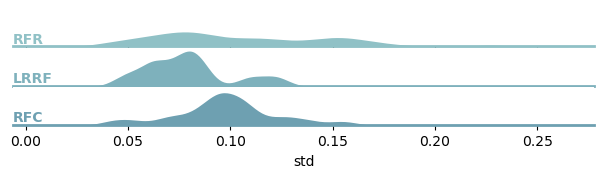

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

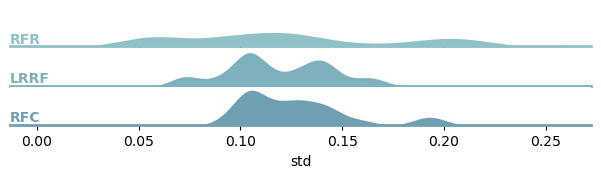

In [49]:
# amine2_dicts = [{}, {}, {}, {}]
# for k, v in amine6_dict.items():
#     for i in range(4) :
#         amine2_dicts[i].update({
#             k:v.iloc[110*i:110*(i+1),:]
#         })
# amine2_dfs = []
# std_by_model = {"model":[], "std":[]}
# for dict_obj in amine2_dicts :
#     for k, v in dict_obj.items():
#         if k in ["RFR", "LRRF", "RFC"] :
#             std_list = []
#             for i in range(11) :
#                 std_list.append(v.iloc[10*i:10*(i+1), -4].std())
#             std_by_model["std"].extend(std_list)
#             std_by_model["model"].extend([k]*len(std_list))
for a in [cat4_dict, cat8_dict, cat12_dict]:
    cat_dicts = [{}, {}]
    for k, v in a.items():
        for i in range(2) :
            cat_dicts[i].update({
                k:v.iloc[110*i:110*(i+1),:]
            })
    cat_dfs = []
    std_by_model = {"model":[], "std":[]}
    for dict_obj in cat_dicts :
        for k, v in dict_obj.items():
            if k in ["RFR", "LRRF", "RFC"] :
                std_list = []
                for i in range(11) :
                    std_list.append(v.iloc[10*i:10*(i+1), -6].std()) # -6 : kendall tau, -4: MRR
                std_by_model["std"].extend(std_list)
                std_by_model["model"].extend([k]*len(std_list))
    df = pd.DataFrame(std_by_model)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "std",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=0.5)
    g.map(sns.kdeplot, "std", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "std")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=.05)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

# NatureHTE dataset analysis

In [37]:
sulfon_dict = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem1rxns.xlsx")
amide_dict = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem1rxns.xlsx")
amine_dict = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem1rxns.xlsx")

RFR
13.9
0.646

Baseline
13.1
0.606

RPC
22.3
0.627

LRRF
18.9
0.622

RFC
18.0
0.633

LR
20.4
0.619

KNN
21.1
0.624



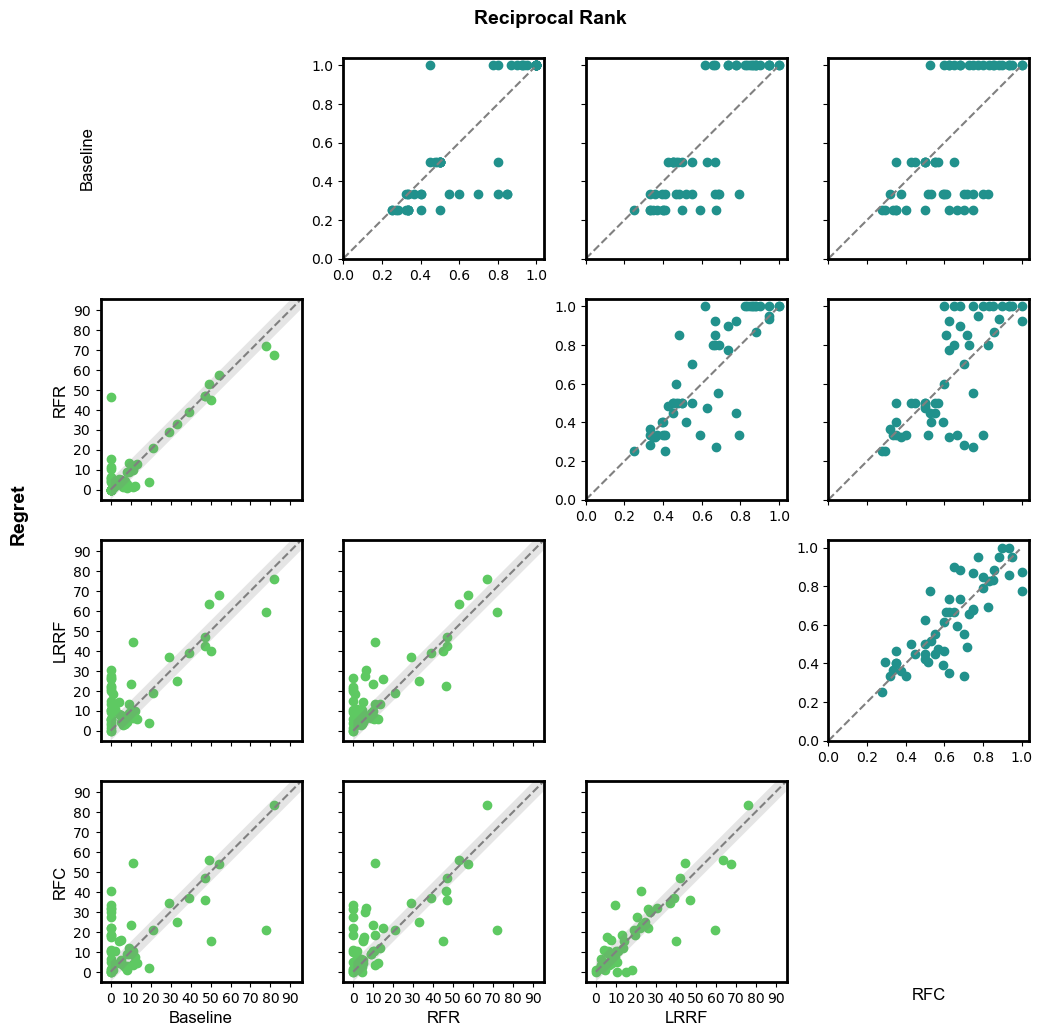

In [38]:
for k, v in amine_dict.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

trellis_of_algs(
        amine_dict,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

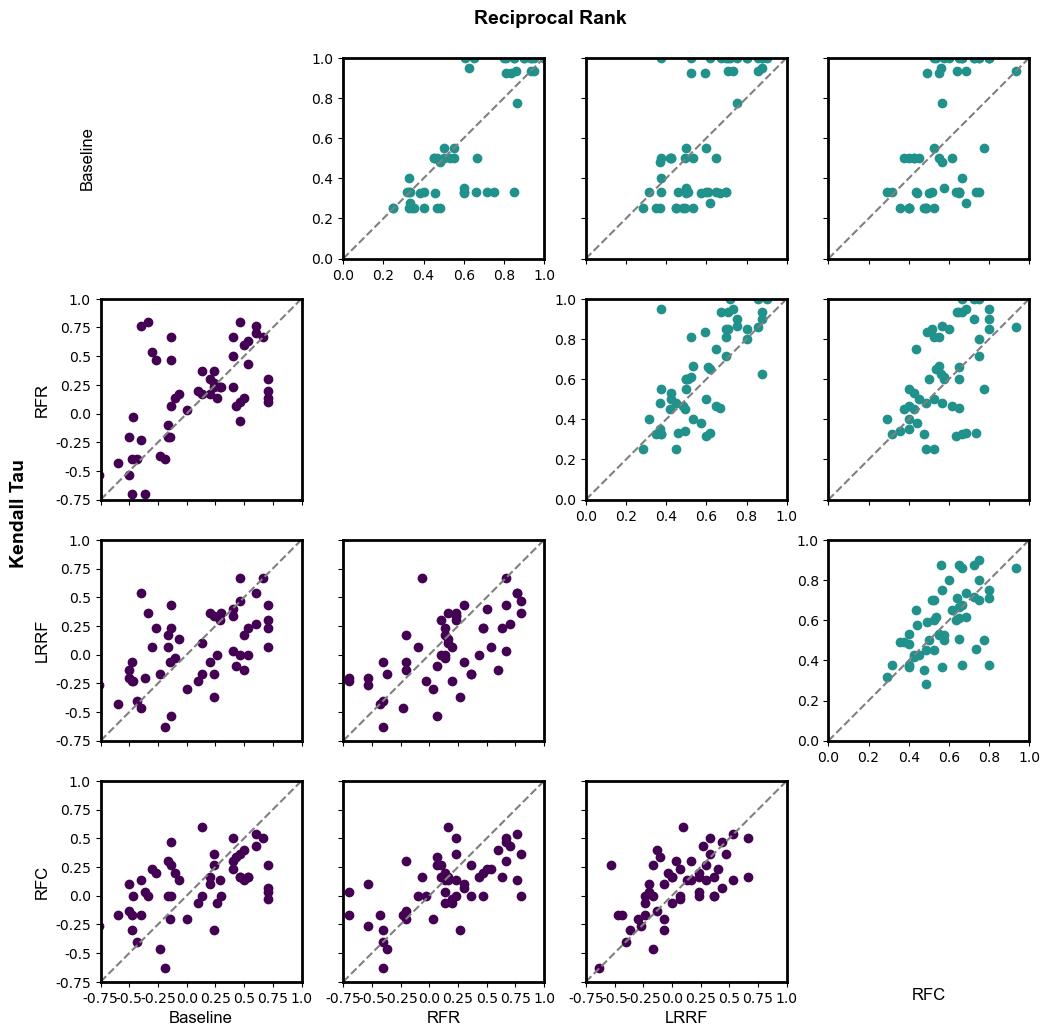

In [93]:
trellis_of_algs(
        amine_dict,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "reciprocal_rank",
        filename=None
    )